In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [32]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns

In [33]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


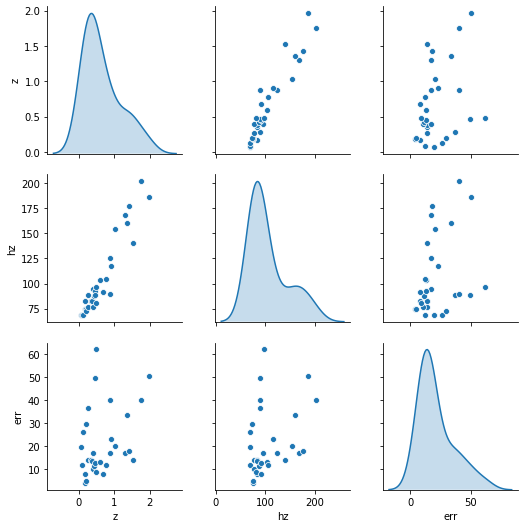

In [34]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [35]:
# a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
#        10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
# randomize = np.random.permutation(len(data.values))
shuffle = [x for x in range(len(data.values)) if x%2 ==0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]
shuffle

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29]

In [36]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [37]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [38]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [39]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [40]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [41]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = RandomNormal()


In [42]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, kernel_initializer=initializer, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, kernel_initializer=initializer, activation='relu')(efirst)
#     elast = Dense(50, kernel_initializer=initializer, activation='relu')(ehidden)
#     #coded
#     coded = Dense(10, kernel_initializer=initializer, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, kernel_initializer=initializer, activation='relu')(coded)
#     dhidden = Dense(50, kernel_initializer=initializer, activation='relu')(dfirst)
#     dlast = Dense(100, kernel_initializer=initializer, activation='relu')(dhidden)
#     decoded = Dense(2, kernel_initializer=initializer, activation='relu')(dlast)
    
#     return decoded

In [43]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, activation='relu')(efirst)
#     elast = Dense(50, activation='relu')(ehidden)
#     coded = Dense(10, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, activation='relu')(coded)
#     dhidden = Dense(50, activation='relu')(dfirst)
#     dlast = Dense(100, activation='relu')(dhidden)
#     decoded = Dense(2, activation='relu')(dlast)
    
#     return decoded

In [44]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='relu')(ehidden2)
    return elast

batch_size = 16
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_6 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


In [45]:
# batch_size = 4
batch_size = 4
epochs = 100
input_z = Input(shape = (1,))

In [46]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [47]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - 0s 67ms/step - loss: 5344.0591 - val_loss: 10955.2822
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 5296.2500 - val_loss: 10875.7021
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 5223.0835 - val_loss: 10760.9111
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 5103.9160 - val_loss: 10589.6143
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 4926.2192 - val_loss: 10322.7715
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 4645.2466 - val_loss: 9908.4639
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 4271.9194 - val_loss: 9287.5459
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 3694.3398 - val_loss: 8442.8008
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 3054.3054 - val_loss: 7290.4956
Epoch 10/100
6/6 [==============================] - 0s 11ms/step

Epoch 81/100
6/6 [==============================] - 0s 8ms/step - loss: 124.8434 - val_loss: 336.3941
Epoch 82/100
6/6 [==============================] - 0s 8ms/step - loss: 125.2911 - val_loss: 364.2264
Epoch 83/100
6/6 [==============================] - 0s 7ms/step - loss: 123.8174 - val_loss: 366.2427
Epoch 84/100
6/6 [==============================] - 0s 8ms/step - loss: 122.8702 - val_loss: 360.8781
Epoch 85/100
6/6 [==============================] - 0s 7ms/step - loss: 123.4683 - val_loss: 355.0937
Epoch 86/100
6/6 [==============================] - 0s 8ms/step - loss: 123.4382 - val_loss: 357.8728
Epoch 87/100
6/6 [==============================] - 0s 9ms/step - loss: 122.6034 - val_loss: 345.3546
Epoch 88/100
6/6 [==============================] - 0s 7ms/step - loss: 122.8094 - val_loss: 362.9559
Epoch 89/100
6/6 [==============================] - 0s 7ms/step - loss: 123.2070 - val_loss: 371.4221
Epoch 90/100
6/6 [==============================] - 0s 8ms/step - loss: 121.3702 -

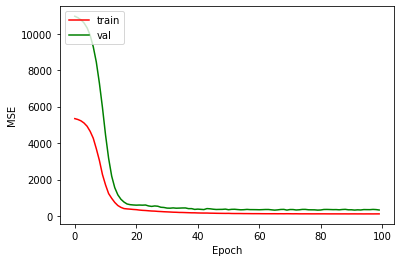

In [48]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_hz.png", dpi=200)


In [49]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])


(328.69879150390625, 120.895263671875)

In [50]:
pred = neural_model.predict(z_test)
pred

array([[ 90.355545,  18.570911],
       [102.44122 ,  20.907015],
       [113.85516 ,  23.210997],
       [115.42291 ,  23.528952],
       [142.66705 ,  29.100931],
       [151.92662 ,  30.993704],
       [175.15723 ,  35.743866]], dtype=float32)

In [51]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [52]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

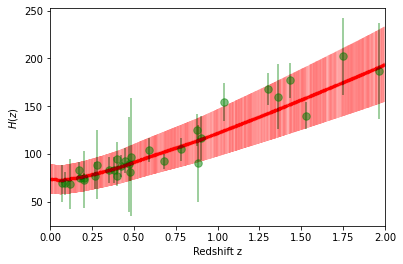

In [53]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("Overfitting_synthetic_HD.png")

In [54]:
# Cosmological constants
Om = 0.27
# variance network


In [25]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

NameError: name 'Hlcdm' is not defined

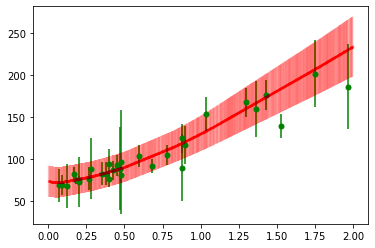

In [30]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

# plt.savefig("SyntheticHDrelu.png",dpi=800)

In [27]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [28]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [29]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("autoEncoderHz100.dat",mookHz, delimiter=" ")

In [30]:
predy_reduced[:,1]

array([28.348413, 23.637205, 31.934431, 18.475437, 26.922392, 20.788263,
       36.068275, 32.49303 , 34.576332, 37.029793, 15.377698, 30.305159,
       28.099457, 27.267817, 40.459984, 16.54183 , 24.68109 , 31.586292,
       24.340998, 20.28022 , 20.647348, 31.435802, 31.580675, 28.224386,
       26.238718, 20.655844, 23.417688, 27.129282, 32.12712 , 37.04203 ,
       25.77029 , 16.358347, 37.00096 , 25.368383, 15.387077, 16.35112 ,
       24.273561, 26.286068, 28.290525, 19.0606  , 15.848478, 24.029587,
       15.384718, 15.389366, 17.15854 , 27.003538, 16.000835, 26.103947,
       18.771503, 15.420841, 15.537949, 15.561562, 36.4038  , 20.805025,
       40.13315 , 18.771503, 17.783262, 29.044563, 26.2949  , 30.668968,
       25.910887, 26.103947, 25.050976, 37.0447  , 35.230125, 25.371393,
       18.099577, 18.233831, 29.78429 , 21.553083, 15.387077, 21.759892,
       18.489088, 36.366997, 33.061836, 15.939865, 34.70414 , 35.75778 ,
       40.450493, 38.997463, 33.43444 , 32.07448 , 

In [31]:
error  = predy_reduced[:,1]**2
error

array([ 803.63257,  558.71747, 1019.80786,  341.34177,  724.8152 ,
        432.1519 , 1300.9205 , 1055.797  , 1195.5227 , 1371.2056 ,
        236.47359,  918.40265,  789.57947,  743.5338 , 1637.0103 ,
        273.63214,  609.1562 ,  997.69385,  592.4842 ,  411.28732,
        426.313  ,  988.20966,  997.33905,  796.61597,  688.47034,
        426.66388,  548.3881 ,  735.9979 , 1032.1519 , 1372.112  ,
        664.10785,  267.59552, 1369.0712 ,  643.5549 ,  236.76215,
        267.35913,  589.2058 ,  690.9574 ,  800.3538 ,  363.3065 ,
        251.17427,  577.421  ,  236.68954,  236.8326 ,  294.41553,
        729.1911 ,  256.02673,  681.416  ,  352.36935,  237.80234,
        241.42784,  242.1622 , 1325.2367 ,  432.84906, 1610.6696 ,
        352.36935,  316.24442,  843.5867 ,  691.4218 ,  940.58563,
        671.374  ,  681.416  ,  627.5514 , 1372.3098 , 1241.1617 ,
        643.7076 ,  327.5947 ,  332.4726 ,  887.10394,  464.5354 ,
        236.76215,  473.4929 ,  341.84637, 1322.5585 , 1093.08

In [32]:
diagcov = np.diag(error) #inverso
# np.savetxt("autoEncoderHz_cov100.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

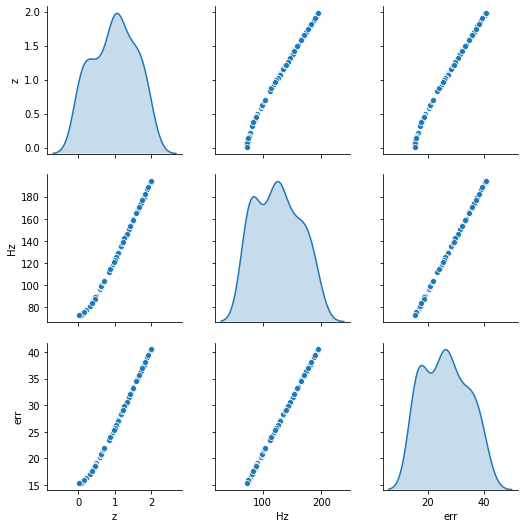

In [33]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("100hdmook.png")

In [34]:
4**4

256